## Machine Learning Model Development

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV,train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f0f0f0"})

### Load Engineered Data

In [2]:
# Load data from Day 2
df = pd.read_csv("QQQ_Engineered_Data.csv", parse_dates=["Date"], index_col="Date")

# Create target variable (1 if next day's close > current day's close)
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df.dropna(subset=["Target"], inplace=True)  # Remove last row with NaN

# Define features (X) and target (y)
X = df.drop(["Close", "Target"], axis=1)  # Exclude raw close price to avoid leakage
y = df["Target"]

print("Class Distribution:")
print(y.value_counts(normalize=True))

Class Distribution:
1    0.558289
0    0.441711
Name: Target, dtype: float64


### Time-Series Split (Avoid Look-Ahead Bias)

In [3]:
# Time-based split (80% train, 20% test)
split_idx = int(0.8 * len(X))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train Dates: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test Dates: {X_test.index.min()} to {X_test.index.max()}")

Train Dates: 2010-02-22 00:00:00 to 2022-01-06 00:00:00
Test Dates: 2022-01-07 00:00:00 to 2024-12-30 00:00:00


### Hyperparameter Tuning with Time-Series CV

In [4]:
# Initialize XGBoost with accuracy-focused parameters
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    early_stopping_rounds=10,
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid (optimized for QQQ)
param_grid = {
    "max_depth": [3, 4],          # Reduced complexity
    "learning_rate": [0.05, 0.1],  # Smaller steps
    "subsample": [0.8, 0.9],       # Prevent overfitting
    "colsample_bytree": [0.8, 1.0],
    "reg_alpha": [0.1, 0.5],       # L1 regularization
    "reg_lambda": [0.1, 0.5]       # L2 regularization
}

# Time-series cross-validation
tscv = TimeSeriesSplit(n_splits=3)
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=tscv,
    scoring="accuracy",
    verbose=1,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train, eval_set=[(X_train, y_train)])

# Best model
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

Fitting 3 folds for each of 64 candidates, totalling 192 fits
[0]	validation_0-logloss:0.68392
[1]	validation_0-logloss:0.68293
[2]	validation_0-logloss:0.68224
[3]	validation_0-logloss:0.68131
[4]	validation_0-logloss:0.68046
[5]	validation_0-logloss:0.67964
[6]	validation_0-logloss:0.67883
[7]	validation_0-logloss:0.67806
[8]	validation_0-logloss:0.67760
[9]	validation_0-logloss:0.67710
[10]	validation_0-logloss:0.67643
[11]	validation_0-logloss:0.67542
[12]	validation_0-logloss:0.67491
[13]	validation_0-logloss:0.67430
[14]	validation_0-logloss:0.67373
[15]	validation_0-logloss:0.67340
[16]	validation_0-logloss:0.67242
[17]	validation_0-logloss:0.67171
[18]	validation_0-logloss:0.67133
[19]	validation_0-logloss:0.67093
[20]	validation_0-logloss:0.67045
[21]	validation_0-logloss:0.66991
[22]	validation_0-logloss:0.66938
[23]	validation_0-logloss:0.66900
[24]	validation_0-logloss:0.66850
[25]	validation_0-logloss:0.66821
[26]	validation_0-logloss:0.66761
[27]	validation_0-logloss:0.66

### Address Class Imbalance

In [5]:
# Split training data into train/validation sets (time-series aware)
X_train_sub, X_val, y_train_sub, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.2, 
    shuffle=False  # Maintain chronological order
)

# Adjust for class imbalance
scale_pos_weight = (len(y_train_sub) - sum(y_train_sub)) / sum(y_train_sub)
best_model.set_params(scale_pos_weight=scale_pos_weight)

# Retrain with validation set for early stopping
best_model.fit(
    X_train_sub, y_train_sub,
    eval_set=[(X_val, y_val)],  # Critical for early stopping
    verbose=True
)

[0]	validation_0-logloss:0.69309
[1]	validation_0-logloss:0.69001
[2]	validation_0-logloss:0.68989
[3]	validation_0-logloss:0.68983
[4]	validation_0-logloss:0.68740
[5]	validation_0-logloss:0.68749
[6]	validation_0-logloss:0.68580
[7]	validation_0-logloss:0.68405
[8]	validation_0-logloss:0.68401
[9]	validation_0-logloss:0.68421
[10]	validation_0-logloss:0.68392
[11]	validation_0-logloss:0.68397
[12]	validation_0-logloss:0.68408
[13]	validation_0-logloss:0.68403
[14]	validation_0-logloss:0.68394
[15]	validation_0-logloss:0.68676
[16]	validation_0-logloss:0.69118
[17]	validation_0-logloss:0.69169
[18]	validation_0-logloss:0.69491
[19]	validation_0-logloss:0.69495
[20]	validation_0-logloss:0.69452


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=-1,
              num_parallel_tree=None, ...)

### Evaluate Model Performance


Test Set Performance:
Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.09      0.15       348
           1       0.54      0.93      0.68       400

    accuracy                           0.54       748
   macro avg       0.53      0.51      0.42       748
weighted avg       0.53      0.54      0.43       748



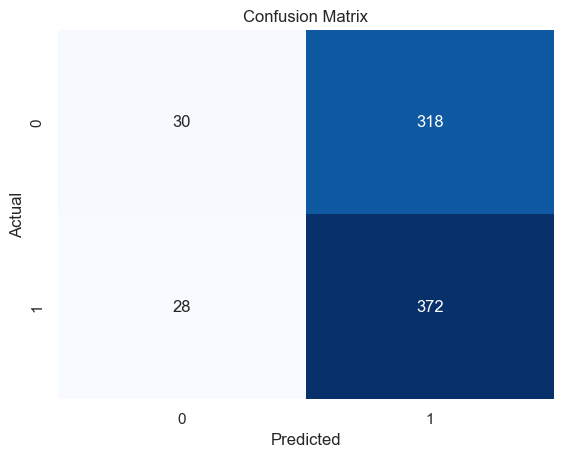

In [6]:
# Test set predictions
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]  # Probabilities for threshold tuning

# Metrics
print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

### Feature Importance Analysis

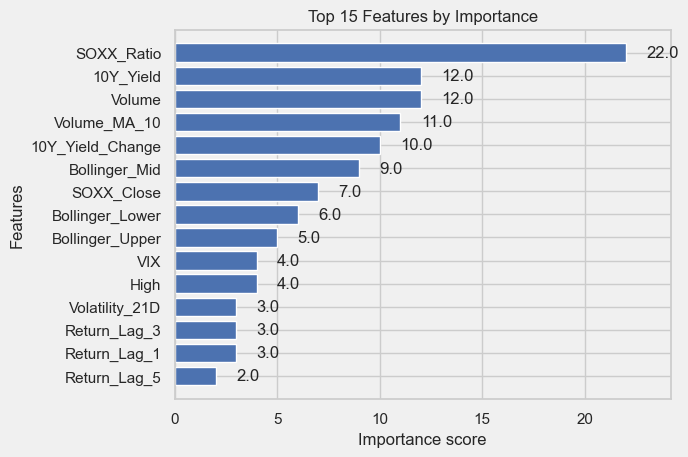

In [7]:
# Plot feature importance
xgb.plot_importance(best_model, max_num_features=15, height=0.8)
plt.title("Top 15 Features by Importance", fontsize=12)
plt.gcf().set_facecolor("#f0f0f0")
plt.show()

# Actionable insight: Drop low-importance features if needed
low_importance_features = ["Volume_MA_10", "VIX_Regime_Low"]  # Example
X_train = X_train.drop(low_importance_features, axis=1, errors="ignore")
X_test = X_test.drop(low_importance_features, axis=1, errors="ignore")

### Save Model

In [8]:
# Save model and feature names
joblib.dump(best_model, "QQQ_XGBoost_Model.pkl")
print("Model saved as 'QQQ_XGBoost_Model.pkl'")

Model saved as 'QQQ_XGBoost_Model.pkl'
